In [89]:
import get_db_data as gdd
import analyze_signal as anaz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
reload(gdd);
reload(anaz);
from sqlalchemy.engine.result import RowProxy
import sqlalchemy as sql
from numpy.linalg import norm
from sklearn.linear_model import LinearRegression 
from decimal import Decimal

In [2]:
con = gdd.get_db_data()

In [150]:
def get_signal_triplets(groups, con):
    for group_id in groups:
        if type(group_id) == RowProxy:
            group_id = group_id[0] #un-tuple
        group_signals = list(con.get_signal_by_series_type_and_interp_type([group_id],2,4))[0]
        yield reshape_group_result(group_signals)
        

def within_group_corr(triplets, detrend_signal=False):
    for trip in triplets:
        #print(trip)
        signals = trip
        if detrend_signal:
           # print("de-trending")
            signals = [detrend(x) for x in signals]
        corrs = np.corrcoef(signals)
        corr_vals = [corrs[0,1], corrs[0,2], corrs[1,2]]
        yield corr_vals

        
def groups_to_corr_df(groups,con):
    group_signals =get_signal_triplets(groups,con)
    group_corrs = within_group_corr(group_signals, True)
    for gr, corr_vals in zip(groups, group_corrs):
        for z, val in enumerate(corr_vals):
            yield gr[0], z, val

            
def detrend(signal):
    x = np.arange(len(signal)).reshape(-1,1)
    y_hat = LinearRegression().fit(x,signal.reshape(-1,1)).predict(x)
    return signal-y_hat.squeeze()


def reshape_group_result(res):
    #print(res)
    _, ind = np.unique(res[:,0],return_index=True)
    ind = list(ind)+[res.shape[0]]
    return [res[ind[i]:ind[i+1],2] for i in range(len(ind)-1)]

In [6]:
con.con.execute("""
INSERT INTO correlation_series
VALUES (null,2,4,null,null,true)
""")

In [11]:
groups = con.con.execute("""
SELECT group_id
FROM participants
GROUP BY group_id
Having count(1)=3""").fetchall()

In [51]:
csg_insert = sql.text("""
INSERT IGNORE INTO correlation_series_groups
VALUES (null,1,:gr,null)""")

csg_id = sql.text("""
SELECT correlation_group_id
FROM correlation_series_groups
WHERE corr_series_id=1
AND group_id=:gr
and group_id_1 IS NULL
LIMIT 1""")

cd_insert = sql.text("""
INSERT INTO correlation_data 
VALUES (null, 1, :cg_id, :data_ord, :data_val)
""")

In [55]:
df = pd.DataFrame(columns = ['correlation_series_id','correlation_group_id','data_ordinal','data_value'])

In [151]:
rows =[]
for gr, z, val in groups_to_corr_df(groups,con):
    con.con.execute(csg_insert, gr=gr)
    print("group {}".format(gr))
    cg_id = con.con.execute(csg_id, gr=gr).fetchall()[0][0]
    rows.append({
        'correlation_series_id': 1,
        'correlation_group_id': cg_id,
        'data_ordinal': z,
        'data_value': Decimal(val)
    })
    #res2=con.con.execute(cd_insert, cg_id=cg_id, data_ord=z, data_val=Decimal(val))
    

group 1001
group 1001
group 1001
group 1004
group 1004
group 1004
group 1005
group 1005
group 1005
group 1006
group 1006
group 1006
group 1007
group 1007
group 1007
group 1008
group 1008
group 1008
group 1009
group 1009
group 1009
group 1010
group 1010
group 1010
group 1011
group 1011
group 1011
group 1012
group 1012
group 1012
group 1013
group 1013
group 1013
group 1014
group 1014
group 1014
group 1016
group 1016
group 1016
group 1019
group 1019
group 1019
group 1020
group 1020
group 1020
group 1022
group 1022
group 1022
group 1023
group 1023
group 1023
group 1024
group 1024
group 1024
group 1025
group 1025
group 1025
group 1026
group 1026
group 1026
group 1027
group 1027
group 1027
group 1028
group 1028
group 1028
group 1029
group 1029
group 1029
group 1030
group 1030
group 1030
group 1031
group 1031
group 1031
group 1032
group 1032
group 1032
group 1033
group 1033
group 1033
group 1034
group 1034
group 1034
group 1035
group 1035
group 1035
group 1036
group 1036
group 1036
group 1037

In [153]:
df=df.append(rows)
df

,correlation_series_id,correlation_group_id,data_ordinal,data_value
0,1,1,0,-0.0152454411609797679111322210587786685209721...
1,1,1,1,0.42985565438233502844056488356727641075849533...
2,1,1,2,0.27752776025774189561090565803169738501310348...
3,1,11,0,0.08386017129292226701675616595821338705718517...
4,1,11,1,0.12848801782832691698033045213378500193357467...
...,...,...,...,...
130,1,296,1,0.13527484903567238427868346661853138357400894...
131,1,296,2,0.02280557715508369290291490472100122133269906...
132,1,299,0,-0.0198276162357206020558919590257573872804641...
133,1,299,1,0.06116512244004239373662556999988737516105175...


In [160]:
df.to_sql('correlation_data',con.con,if_exists='append',index=False)

/home/siegman/miniconda3/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1265, "Data truncated for column 'data_value' at row 1")
  result = self._query(query)
/home/siegman/miniconda3/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1265, "Data truncated for column 'data_value' at row 2")
  result = self._query(query)
/home/siegman/miniconda3/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1265, "Data truncated for column 'data_value' at row 3")
  result = self._query(query)
/home/siegman/miniconda3/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1265, "Data truncated for column 'data_value' at row 4")
  result = self._query(query)
/home/siegman/miniconda3/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1265, "Data truncated for column 'data_value' at row 5")
  result = self._query(query)
/home/siegman/miniconda3/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1265, "Data truncated for column 'data_valu

In [147]:
a[3].shape

IndexError: list index out of range

In [48]:
Decimal(round(np.pi,4))

Decimal('3.141599999999999948130380289512686431407928466796875')

In [57]:
df.append([1,2,3,4])

,0,correlation_group_id,correlation_series_id,data_ordinal,data_value
0,1.0,NaN,NaN,NaN,NaN
1,2.0,NaN,NaN,NaN,NaN
2,3.0,NaN,NaN,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN


In [58]:
df

,correlation_series_id,correlation_group_id,data_ordinal,data_value


In [62]:

g1020 = list(con.get_signal_by_series_type_and_interp_type([158,159,160],2,4))


In [103]:

gp= list(con.get_signal_by_series_type_and_interp_type([1016],2,4))


In [66]:
[len(h[1]) for h in gp]

[3]

In [104]:
gp

[array([[146.     ,   2.25   ,   0.66349],
        [146.     ,   2.5    ,   0.66605],
        [146.     ,   2.75   ,   0.6648 ],
        ...,
        [148.     , 287.75   ,   0.51924],
        [148.     , 288.     ,   0.52103],
        [148.     , 288.25   ,   0.52161]])]

In [123]:
def reshape_group_result(res):
    res=res[0]
    _, ind = np.unique(res[:,0],return_index=True)
    ind = list(ind)+[res.shape[0]]
    return np.vstack([res[ind[i]:ind[i+1],2] for i in range(len(ind)-1)]).T

In [124]:
reshape_group_result(gp).T

[   0 1145 2290]
[0, 1145, 2290, 3437]


array([[0.66349, 0.67993, 0.52406],
       [0.66605, 0.6805 , 0.52969],
       [0.6648 , 0.67925, 0.53713],
       ...,
       [0.64535, 0.71506, 0.51924],
       [0.63103, 0.70503, 0.52103],
       [0.60919, 0.70549, 0.52161]])

In [125]:
gp[0].shape[0]

3435

In [107]:
par, ind = np.unique(gp[0][:,0],return_index=True)

In [117]:
_, ind = np.unique(gp[0][:,0],return_index=True)

In [118]:
ind

array([   0, 1145, 2290])

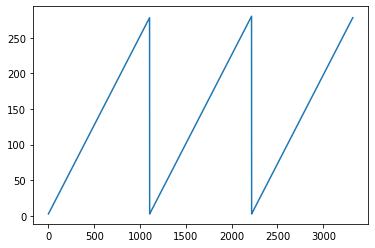

In [82]:
plt.plot(gp[0][:,1])

In [83]:
np.unique(np.diff(gp[0][:,1]))

array([-2.78e+02, -2.76e+02,  2.50e-01])

In [87]:
gp0 = gp[0]
np.min(gp0[:1105,1]),np.min(gp0[1105:2218,1]),np.min(gp0[2218:,1])

(2.5, 2.5, 2.5)

In [88]:
np.max(gp0[:1105,1]),np.max(gp0[1105:2218,1]),np.max(gp0[2218:,1])

(278.5, 280.5, 278.5)

In [126]:
np.arange(3)[:3]

array([0, 1, 2])